In [ ]:
# default_exp auto

In [ ]:
#export
import numpy as np
import pandas as pd
from hyperopt import hp
import pytorch_lightning as pl

from neuralforecast.experiments.utils import hyperopt_tunning

## Base class

In [ ]:
#export
class AutoBaseModel(object):
    def __init__(self, n_time_out):
        super(AutoBaseModel, self).__init__()

        self.n_time_out = n_time_out

    def fit(self, Y_df, X_df, S_df, hyperopt_steps, loss_function_val, n_ts_val, results_dir,
            save_trials=False, loss_functions_test=None, n_ts_test=0, return_test_forecast=False, verbose=False):

        # The suggested spaces are partial, here we complete them with data specific information
        self.space['n_series']   = hp.choice('n_series', [ Y_df['unique_id'].nunique() ])
        self.space['n_x']        = hp.choice('n_x', [ 0 if X_df is None else (X_df.shape[1]-2) ])
        self.space['n_s']        = hp.choice('n_s', [ 0 if S_df is None else (S_df.shape[1]-1) ])
        self.space['n_x_hidden'] = hp.choice('n_x_hidden', [ 0 if X_df is None else (X_df.shape[1]-2) ])
        self.space['n_s_hidden'] = hp.choice('n_s_hidden', [ 0 if S_df is None else (S_df.shape[1]-1) ])

        # Infers freq with first time series
        freq = pd.infer_freq(Y_df[Y_df['unique_id']==Y_df.unique_id.unique()[0]]['ds']) 
        self.space['frequency']  = hp.choice('frequency', [ freq ])

        self.model, self.trials = hyperopt_tunning(space=self.space,
                                                   hyperopt_max_evals=hyperopt_steps,
                                                   loss_function_val=loss_function_val,
                                                   loss_functions_test=loss_functions_test,
                                                   S_df=S_df, Y_df=Y_df, X_df=X_df, 
                                                   f_cols=[], ds_in_val=n_ts_val, 
                                                   ds_in_test=n_ts_test,
                                                   return_forecasts=return_test_forecast,
                                                   return_model=True,
                                                   save_trials=save_trials,
                                                   results_dir=results_dir,
                                                   step_save_progress=5,
                                                   verbose=verbose)
        
        return self

    def forecast(self, Y_df: pd.DataFrame, X_df: pd.DataFrame = None, S_df: pd.DataFrame = None, 
                 batch_size: int =1, trainer: pl.Trainer =None) -> pd.DataFrame:
        
        return self.model.forecast(Y_df=Y_df, X_df=X_df, S_df=S_df, batch_size=batch_size, trainer=trainer)

## AutoNHITS

In [ ]:
#export
class NHITS(AutoBaseModel):
    def __init__(self, n_time_out, space=None):
        super(NHITS, self).__init__(n_time_out)

        if space is None:
            space = nhits_space(n_time_out=n_time_out)
        self.space = space


def nhits_space(n_time_out: int) -> dict:
    """
    Suggested hyperparameters search space for tuning. To be used with hyperopt library.

    Parameters
    ----------
    n_time_out: int
        Forecasting horizon.

    Returns
    ----------
    space: Dict
        Dictionary with search space for hyperopt library.
    """

    space= {# Architecture parameters
            'model':'nhits',
            'mode': 'simple',
            'n_time_in': hp.choice('n_time_in', [2*n_time_out, 3*n_time_out, 5*n_time_out]),
            'n_time_out': hp.choice('n_time_out', [n_time_out]),
            'shared_weights': hp.choice('shared_weights', [False]),
            'activation': hp.choice('activation', ['ReLU']),
            'initialization':  hp.choice('initialization', ['lecun_normal']),
            'stack_types': hp.choice('stack_types', [ 3*['identity'] ]),
            'constant_n_blocks': hp.choice('n_blocks', [ 1, 3 ]), # Constant n_blocks across stacks
            'constant_n_layers': hp.choice('n_layers', [ 2, 3 ]), # Constant n_layers across stacks
            'constant_n_mlp_units': hp.choice('n_mlp_units', [ 128, 256, 512, 1024 ]), # Constant n_mlp_units across stacks
            'n_pool_kernel_size': hp.choice('n_pool_kernel_size', [ 3*[1], 3*[2], 3*[4], 3*[8], [8, 4, 1], [16, 8, 1] ]),
            'n_freq_downsample': hp.choice('n_freq_downsample', [ [168, 24, 1], [24, 12, 1],
                                                                     [180, 60, 1], [60, 8, 1],
                                                                     [40, 20, 1] ]),
            'pooling_mode': hp.choice('pooling_mode', [ 'max' ]),
            'interpolation_mode': hp.choice('interpolation_mode', [ 'linear' ]),
            # Regularization and optimization parameters
            'batch_normalization': hp.choice('batch_normalization', [False]),
            'dropout_prob_theta': hp.choice('dropout_prob_theta', [ 0 ]),
            'learning_rate': hp.choice('learning_rate', [0.0001, 0.001, 0.005, 0.01]),
            'lr_decay': hp.choice('lr_decay', [0.5] ),
            'n_lr_decays': hp.choice('n_lr_decays', [3]), 
            'weight_decay': hp.choice('weight_decay', [0] ),
            'max_epochs': hp.choice('max_epochs', [None]),
            'max_steps': hp.choice('max_steps', [1_000, 3_000, 5_000]),
            'early_stop_patience': hp.choice('early_stop_patience', [10]),
            'eval_freq': hp.choice('eval_freq', [50]),
            'loss_train': hp.choice('loss', ['MAE']),
            'loss_hypar': hp.choice('loss_hypar', [0.5]),   
            'loss_valid': hp.choice('loss_valid', ['MAE']),
            # Data parameters
            'normalizer_y': hp.choice('normalizer_y', [None]),
            'normalizer_x': hp.choice('normalizer_x', [None]),
            'complete_windows':  hp.choice('complete_windows', [True]),
            'idx_to_sample_freq': hp.choice('idx_to_sample_freq', [1]),
            'val_idx_to_sample_freq': hp.choice('val_idx_to_sample_freq', [1]),
            'batch_size': hp.choice('batch_size', [1]),
            'n_windows': hp.choice('n_windows', [32, 64, 128, 256, 512]),
            'random_seed': hp.quniform('random_seed', 1, 20, 1)}

    return space

## AutoNBEATS

In [ ]:
#export
class NBEATS(AutoBaseModel):
    def __init__(self, n_time_out, space=None):
        super(NBEATS, self).__init__(n_time_out)

        if space is None:
            space = nbeats_space(n_time_out=n_time_out)
        self.space = space

def nbeats_space(n_time_out: int) -> dict:
    """
    Suggested hyperparameters search space for tuning. To be used with hyperopt library.

    Parameters
    ----------
    n_time_out: int
        Forecasting horizon.
    
    Returns
    ----------
    space: Dict
        Dictionary with search space for hyperopt library.
    """

    space= {# Architecture parameters
            'model':'nbeats',
            'mode': 'simple',
            'n_time_in': hp.choice('n_time_in', [2*n_time_out, 3*n_time_out, 5*n_time_out]),
            'n_time_out': hp.choice('n_time_out', [n_time_out]),
            'shared_weights': hp.choice('shared_weights', [False]),
            'activation': hp.choice('activation', ['ReLU']),
            'initialization':  hp.choice('initialization', ['lecun_normal']),
            'stack_types': hp.choice('stack_types', [ 3*['identity'] ]),
            'constant_n_blocks': hp.choice('n_blocks', [ 1, 3 ]), # Constant n_blocks across stacks
            'constant_n_layers': hp.choice('n_layers', [ 2, 3 ]), # Constant n_layers across stacks
            'constant_n_mlp_units': hp.choice('n_mlp_units', [ 128, 256, 512, 1024 ]), # Constant n_mlp_units across stacks
            # Regularization and optimization parameters
            'batch_normalization': hp.choice('batch_normalization', [False]),
            'dropout_prob_theta': hp.choice('dropout_prob_theta', [ 0 ]),
            'learning_rate': hp.choice('learning_rate', [0.0001, 0.001, 0.005, 0.01]),
            'lr_decay': hp.choice('lr_decay', [0.5] ),
            'n_lr_decays': hp.choice('n_lr_decays', [3]), 
            'weight_decay': hp.choice('weight_decay', [0] ),
            'max_epochs': hp.choice('max_epochs', [None]),
            'max_steps': hp.choice('max_steps', [1_000, 3_000, 5_000]),
            'early_stop_patience': hp.choice('early_stop_patience', [10]),
            'eval_freq': hp.choice('eval_freq', [50]),
            'loss_train': hp.choice('loss', ['MAE']),
            'loss_hypar': hp.choice('loss_hypar', [0.5]),                
            'loss_valid': hp.choice('loss_valid', ['MAE']),
            # Data parameters
            'normalizer_y': hp.choice('normalizer_y', [None]),
            'normalizer_x': hp.choice('normalizer_x', [None]),
            'complete_windows':  hp.choice('complete_windows', [True]),
            'idx_to_sample_freq': hp.choice('idx_to_sample_freq', [1]),
            'val_idx_to_sample_freq': hp.choice('val_idx_to_sample_freq', [1]),
            'batch_size': hp.choice('batch_size', [1]),
            'n_windows': hp.choice('n_windows', [32, 64, 128, 256, 512]),
            'random_seed': hp.quniform('random_seed', 1, 20, 1)}

    return space

## AutoRNN

In [ ]:
#export
class RNN(AutoBaseModel):
    def __init__(self, n_time_out, space=None):
        super(RNN, self).__init__(n_time_out)

        if space is None:
            space = rnn_space(n_time_out=n_time_out)
        self.space = space

def rnn_space(n_time_out: int) -> dict:
    """
    Suggested hyperparameters search space for tuning. To be used with hyperopt library.
    This space is not complete for training, will be completed automatically within
    the fit method of the AutoBaseModels.

        Parameters
        ----------
        n_time_out: int
            Forecasting horizon

        Returns
        ----------
        space: Dict
            Dictionary with search space for hyperopt library.
    """

    space= {# Architecture parameters
            'model':'rnn',
            'mode': 'full',
            'n_time_in': hp.choice('n_time_in', [1*n_time_out, 2*n_time_out, 3*n_time_out]),
            'n_time_out': hp.choice('n_time_out', [n_time_out]),
            'cell_type': hp.choice('cell_type', ['LSTM', 'GRU']),
            'state_hsize': hp.choice('state_hsize', [10, 20, 50, 100]),
            'dilations': hp.choice('dilations', [ [[1, 2]], [[1, 2, 4, 8]], [[1,2],[4,8]] ]),
            'add_nl_layer': hp.choice('add_nl_layer', [ False ]),
            'sample_freq': hp.choice('sample_freq', [1]),
            # Regularization and optimization parameters
            'learning_rate': hp.choice('learning_rate', [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1]),
            'lr_decay': hp.choice('lr_decay', [0.5] ),
            'n_lr_decays': hp.choice('n_lr_decays', [3]), 
            'gradient_eps': hp.choice('gradient_eps', [1e-8]),
            'gradient_clipping_threshold': hp.choice('gradient_clipping_threshold', [10]),
            'weight_decay': hp.choice('weight_decay', [0]),
            'noise_std': hp.choice('noise_std', [0.001]),
            'max_epochs': hp.choice('max_epochs', [None]),
            'max_steps': hp.choice('max_steps', [500, 1000]),
            'early_stop_patience': hp.choice('early_stop_patience', [10]),
            'eval_freq': hp.choice('eval_freq', [50]),
            'loss_train': hp.choice('loss', ['MAE']),
            'loss_hypar': hp.choice('loss_hypar', [0.5]),                
            'loss_valid': hp.choice('loss_valid', ['MAE']),
            # Data parameters
            'normalizer_y': hp.choice('normalizer_y', [None]),
            'normalizer_x': hp.choice('normalizer_x', [None]),
            'complete_windows':  hp.choice('complete_windows', [True]),
            'idx_to_sample_freq': hp.choice('idx_to_sample_freq', [1]),
            'val_idx_to_sample_freq': hp.choice('val_idx_to_sample_freq', [1]),
            'batch_size': hp.choice('batch_size', [16, 32, 64]),
            'n_windows': hp.choice('n_windows', [None]),
            'random_seed': hp.quniform('random_seed', 1, 20, 1)}

    return space

## AutoNF

In [ ]:
#export
MODEL_DICT = {'nbeats': NBEATS,
              'nhits': NHITS,
              'rnn': RNN}

In [ ]:
#export
class AutoNF(object):
    def __init__(self, config_dict, n_time_out):
        super(AutoNF, self).__init__()

        self.config_dict = config_dict
        self.n_time_out = n_time_out

    """
    The AutoNF class is an automated machine learning class that simultaneously explores hyperparameters 
    and optimizes the supported models.

    AutoNF selects from a curated set of well-performing neural forecasting models {N-BEATSx, N-HiTS, RNN} by 
    tunning their hyperparameters with a shared optimization toolkit, using rolling window cross-validation.
    The method helps to improve the comparability across model baselines and make the models 
    available for non-Machine Learning experts.

    The AutoNF class inherits the optimized neural forecast `fit` and `predict` methods.
    """

    def fit(self, 
            Y_df: pd.DataFrame, X_df: pd.DataFrame, S_df: pd.DataFrame,
            loss_function_val: callable, loss_functions_test: dict, 
            n_ts_val: int, n_ts_test: int,
            results_dir: str,
            return_forecasts: bool = False,
            verbose: bool = False):
        """
        This function automatically fits and selects best performing model from
        the config_dict. 

            Parameters
            ----------
            config_dict: Dict
                Dictionary with configuration. Keys should be name of models.
                For each model specify the hyperparameter space 
                (None will use default suggested space), hyperopt steps and timeout.
            Y_df: pd.DataFrame
                Target time series with columns ['unique_id', 'ds', 'y'].
            X_df: pd.DataFrame
                Exogenous time series with columns ['unique_id', 'ds', 'y'].
            S_df: pd.DataFrame
                Static exogenous variables with columns ['unique_id', 'ds']. 
                and static variables. 
            loss_function_val: function
                Loss function used for validation.
            loss_functions_test: Dictionary
                Loss functions used for test evaluation. 
                (function name: string, function: fun)
            ts_in_val: int
                Number of timestamps in validation.
            ts_in_test: int
                Number of timestamps in test.
            return_forecasts: bool
                If true return forecast on test.
            verbose:
                If true, will print summary of dataset, model and training.
        """

        models = self.config_dict.keys()
        assert all(model in MODEL_DICT for model in models), \
                f'One of the models in model_config is not correct. Models available are {MODEL_DICT.keys()}.'

        # Hyperopt
        output_dict = {}
        best_model  = None
        best_loss   = np.inf
        for model_str in models:
            print('MODEL: ', model_str)
            model_config = self.config_dict[model_str]
            
            # Run automated hyperparameter optimization
            hyperopt_steps = model_config['hyperopt_steps']
            results_dir_model = f'{results_dir}/{model_str}'
            model = MODEL_DICT[model_str](n_time_out=self.n_time_out, space=model_config['space'])

            model.fit(Y_df=Y_df, X_df=X_df, S_df=S_df, hyperopt_steps=hyperopt_steps,
                      n_ts_val=n_ts_val,
                      n_ts_test=n_ts_test,
                      results_dir=results_dir_model,
                      save_trials=False,
                      loss_function_val=loss_function_val,
                      loss_functions_test=loss_functions_test,
                      return_test_forecast=return_forecasts,
                      verbose=verbose)

            # Save results in dict
            trials = model.trials

            model_output = {'best_mc': trials.best_trial['result']['mc'],
                            'run_time': trials.best_trial['result']['run_time'],
                            'best_val_loss': trials.best_trial['result']['loss']}

            # Return model
            model_output['model'] = model

            # Return test losses
            if n_ts_test > 0:
                model_output['best_test_loss'] = trials.best_trial['result']['test_losses']

            # Return test forecasts
            if (return_forecasts) and (n_ts_test > 0):
                model_output['y_hat'] = trials.best_trial['result']['forecasts_test']['test_y_hat']
                model_output['y_true'] = trials.best_trial['result']['forecasts_test']['test_y_true']

            # Improvement
            optimization_times = [trials.trials[0]['result']['loss']]
            optimization_losses = [trials.trials[0]['result']['run_time']]
            for i in range(1, len(trials)):
                loss = trials.trials[i]['result']['loss']
                time = trials.trials[i]['result']['run_time']

                if loss > np.min(optimization_losses):
                    loss = np.min(optimization_losses)
                optimization_losses.append(loss)
                optimization_times.append(np.sum(optimization_times)+time)

            model_output['optimization_losses'] = optimization_losses
            model_output['optimization_times'] = optimization_times
        
            # Append to dict
            output_dict[model_str] = model_output

            if trials.best_trial['result']['loss'] < best_loss:
                best_model = model
                best_loss = trials.best_trial['result']['loss']

        self.best_model = best_model
        self.results_dict = output_dict

    def forecast(self, Y_df: pd.DataFrame, X_df: pd.DataFrame = None, S_df: pd.DataFrame = None, 
                 batch_size: int =1, trainer: pl.Trainer =None) -> pd.DataFrame:
        
        return self.best_model.forecast(Y_df=Y_df, X_df=X_df, S_df=S_df, 
                                        batch_size=batch_size, trainer=trainer)

# Examples

The forecasting task we selected is to predict the number of patients with influenza-like illnesses from the [US CDC dataset](https://gis.cdc.gov/grasp/fluview/fluportaldashboard.html), the dataset contains 7 target variables, and has 966 weeks of history.

We will be creating point forecasts with N-BEATS, N-HiTS and RNN models. The predictive features will be the autoregressive features. More information on the dataset can be found in the [N-HiTS paper](https://arxiv.org/abs/2201.12886).

Table of Contents
1.   [Installing NeuralForecast Library](#cell-1)
2.   [Data Loading and Processing](#cell-2)
3.   [Define Hyperparameter Space](#cell-3)
4.   [Hyperparameter Tuning](#cell-4)
5.   [Evaluate Results](#cell-5)

<a name="cell-1"></a>
### 1. Installing Neuralforecast library

You can install the released version of NeuralForecast from the Python package index with:

In [ ]:
#%%capture
#!pip install neuralforecast
#!pip install matplotlib

import matplotlib.pyplot as plt
import neuralforecast as nf
from neuralforecast.data.datasets.long_horizon import LongHorizon

<a name="cell-2"></a>
### 2. Data Loading and Processing

For this example we keep 10% of the observations as validation and use the latest 20% of the observations as the test set. To do so we use the sample_mask and declare the windows that will be used to train, and validate the model.

In [ ]:
Y_df, _, _ = LongHorizon.load(directory='./', group='ILI')
Y_df.head()

,unique_id,ds,y
0,% WEIGHTED ILI,2002-01-01,-0.421499
1,% WEIGHTED ILI,2002-01-08,-0.331239
2,% WEIGHTED ILI,2002-01-15,-0.342763
3,% WEIGHTED ILI,2002-01-22,-0.199782
4,% WEIGHTED ILI,2002-01-29,-0.218426


In [ ]:
n_series = len(Y_df.unique_id.unique())
n_time = len(Y_df.ds.unique()) # dataset is balanced

n_ts_test = 193
n_ts_val = 97

print('n_time', n_time)
print('n_series', n_series)
print('n_ts_test', n_ts_test)
print('n_ts_val', n_ts_val)

n_time 966
n_series 7
n_ts_test 193
n_ts_val 97


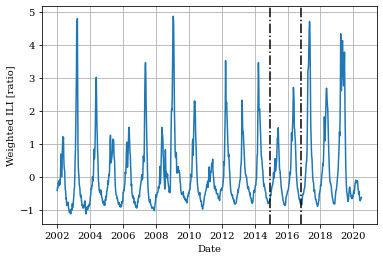

In [ ]:
# unique_id \in ['% WEIGHTED ILI', '%UNWEIGHTED ILI', 'AGE 0-4', 
#                'AGE 5-24', 'ILITOTAL', 'NUM. OF PROVIDERS', 'OT']
y_plot = Y_df[Y_df.unique_id=='% WEIGHTED ILI'].y.values
x_plot = pd.to_datetime(Y_df[Y_df.unique_id=='% WEIGHTED ILI'].ds).values

plt.plot(x_plot, y_plot)
plt.axvline(x_plot[n_time-n_ts_val-n_ts_test], color='black', linestyle='-.')
plt.axvline(x_plot[n_time-n_ts_test], color='black', linestyle='-.')
plt.ylabel('Weighted ILI [ratio]')
plt.xlabel('Date')
plt.grid()
plt.show()
plt.close()

### 3.0 auto.NHITS

In [ ]:
auto_nhits = NHITS(n_time_out=24)
auto_nhits.space['max_steps'] = hp.choice('max_steps', [1]) # Override max_steps for faster example

In [ ]:
auto_nhits.fit(Y_df=Y_df, X_df=None, S_df=None, hyperopt_steps=2,
               n_ts_val=n_ts_val,
               n_ts_test=n_ts_test,
               results_dir='./results/autonhits',
               save_trials=True,
               loss_function_val=nf.losses.numpy.mae,
               loss_functions_test={'mae':nf.losses.numpy.mae,
                                    'mse':nf.losses.numpy.mse},
               return_test_forecast=True,
               verbose=False)

INFO:hyperopt.tpe:build_posterior_wrapper took 0.014366 seconds
INFO:hyperopt.tpe:TPE using 0 trials
/Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/Users/cchallu/opt/anaconda3/envs/

In [ ]:
forecasts = auto_nhits.forecast(Y_df=Y_df)
forecasts

INFO:root:Train Validation splits

INFO:root:                                      ds           
                                     min        max
unique_id         sample_mask                      
% WEIGHTED ILI    0           2002-01-01 2020-06-30
                  1           2020-07-07 2020-12-15
%UNWEIGHTED ILI   0           2002-01-01 2020-06-30
                  1           2020-07-07 2020-12-15
AGE 0-4           0           2002-01-01 2020-06-30
                  1           2020-07-07 2020-12-15
AGE 5-24          0           2002-01-01 2020-06-30
                  1           2020-07-07 2020-12-15
ILITOTAL          0           2002-01-01 2020-06-30
                  1           2020-07-07 2020-12-15
NUM. OF PROVIDERS 0           2002-01-01 2020-06-30
                  1           2020-07-07 2020-12-15
OT                0           2002-01-01 2020-06-30
                  1           2020-07-07 2020-12-15
INFO:root:
Total data 			6930 time stamps 
Available percentage=100.0, 

Predicting: 100%|██████████| 7/7 [00:00<00:00, 482.03it/s]


/Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


,unique_id,ds,y
0,% WEIGHTED ILI,2020-07-07,-1.265398
1,% WEIGHTED ILI,2020-07-14,-3.120025
2,% WEIGHTED ILI,2020-07-21,-3.601343
3,% WEIGHTED ILI,2020-07-28,-5.753497
4,% WEIGHTED ILI,2020-08-04,-5.873628
...,...,...,...
163,OT,2020-11-17,-4.912064
164,OT,2020-11-24,-3.569168
165,OT,2020-12-01,-3.541500
166,OT,2020-12-08,-4.298891


### 3.1 auto.NBEATS

In [ ]:
auto_nbeats = NBEATS(n_time_out=24)
auto_nbeats.space['max_steps'] = hp.choice('max_steps', [1]) # Override max_steps for faster example

In [ ]:
auto_nbeats.fit(Y_df=Y_df, X_df=None, S_df=None, hyperopt_steps=2,
                n_ts_val=n_ts_val,
                n_ts_test=n_ts_test,
                results_dir='./results/autonbeats',
                save_trials=True,
                loss_function_val=nf.losses.numpy.mae,
                loss_functions_test={'mae':nf.losses.numpy.mae,
                                     'mse':nf.losses.numpy.mse},
                return_test_forecast=True,
                verbose=False)

INFO:hyperopt.tpe:build_posterior_wrapper took 0.012296 seconds
INFO:hyperopt.tpe:TPE using 0 trials
/Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not hav

In [ ]:
forecasts = auto_nbeats.forecast(Y_df=Y_df)
forecasts

INFO:root:Train Validation splits

INFO:root:                                      ds           
                                     min        max
unique_id         sample_mask                      
% WEIGHTED ILI    0           2002-01-01 2020-06-30
                  1           2020-07-07 2020-12-15
%UNWEIGHTED ILI   0           2002-01-01 2020-06-30
                  1           2020-07-07 2020-12-15
AGE 0-4           0           2002-01-01 2020-06-30
                  1           2020-07-07 2020-12-15
AGE 5-24          0           2002-01-01 2020-06-30
                  1           2020-07-07 2020-12-15
ILITOTAL          0           2002-01-01 2020-06-30
                  1           2020-07-07 2020-12-15
NUM. OF PROVIDERS 0           2002-01-01 2020-06-30
                  1           2020-07-07 2020-12-15
OT                0           2002-01-01 2020-06-30
                  1           2020-07-07 2020-12-15
INFO:root:
Total data 			6930 time stamps 
Available percentage=100.0, 

Predicting: 100%|██████████| 7/7 [00:00<00:00, 545.29it/s]


,unique_id,ds,y
0,% WEIGHTED ILI,2020-07-07,-0.568923
1,% WEIGHTED ILI,2020-07-14,-1.287022
2,% WEIGHTED ILI,2020-07-21,-0.459948
3,% WEIGHTED ILI,2020-07-28,-0.598790
4,% WEIGHTED ILI,2020-08-04,-0.275242
...,...,...,...
163,OT,2020-11-17,4.172915
164,OT,2020-11-24,3.797713
165,OT,2020-12-01,4.516331
166,OT,2020-12-08,4.072850


### 3.1 auto.RNN

In [ ]:
auto_rnn = RNN(n_time_out=24)
auto_rnn.space['max_steps'] = hp.choice('max_steps', [1]) # Override max_steps for faster example

In [ ]:
auto_rnn.fit(Y_df=Y_df, X_df=None, S_df=None, hyperopt_steps=2,
             n_ts_val=n_ts_val,
             n_ts_test=n_ts_test,
             results_dir='./results/autornn',
             save_trials=True,
             loss_function_val=nf.losses.numpy.mae,
             loss_functions_test={'mae':nf.losses.numpy.mae,
                                  'mse':nf.losses.numpy.mse},
             return_test_forecast=True,
             verbose=False)

INFO:hyperopt.tpe:build_posterior_wrapper took 0.013226 seconds
INFO:hyperopt.tpe:TPE using 0 trials
/Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not hav

In [ ]:
forecasts = auto_rnn.forecast(Y_df=Y_df)
forecasts

INFO:root:Train Validation splits

INFO:root:                                      ds           
                                     min        max
unique_id         sample_mask                      
% WEIGHTED ILI    0           2002-01-01 2020-06-30
                  1           2020-07-07 2020-12-15
%UNWEIGHTED ILI   0           2002-01-01 2020-06-30
                  1           2020-07-07 2020-12-15
AGE 0-4           0           2002-01-01 2020-06-30
                  1           2020-07-07 2020-12-15
AGE 5-24          0           2002-01-01 2020-06-30
                  1           2020-07-07 2020-12-15
ILITOTAL          0           2002-01-01 2020-06-30
                  1           2020-07-07 2020-12-15
NUM. OF PROVIDERS 0           2002-01-01 2020-06-30
                  1           2020-07-07 2020-12-15
OT                0           2002-01-01 2020-06-30
                  1           2020-07-07 2020-12-15
INFO:root:
Total data 			6930 time stamps 
Available percentage=100.0, 

Predicting: 100%|██████████| 7/7 [00:00<00:00, 22.68it/s]


,unique_id,ds,y
0,% WEIGHTED ILI,2020-07-07,-0.183406
1,% WEIGHTED ILI,2020-07-14,0.073594
2,% WEIGHTED ILI,2020-07-21,0.015090
3,% WEIGHTED ILI,2020-07-28,-0.280709
4,% WEIGHTED ILI,2020-08-04,-0.053751
...,...,...,...
163,OT,2020-11-17,0.325544
164,OT,2020-11-24,0.039716
165,OT,2020-12-01,0.341176
166,OT,2020-12-08,0.412436


# 4. AutoNF

<a name="cell-3"></a>
### Define Hyperparameter Space

A temporal train-evaluation split procedure allows us to estimate the model’s generalization performance on future data unseen by the model. We use the train set to optimize the model parameters, and the validation  and test sets to evaluate the accuracy of the model’s predictions.

In this case we set the space to `None`, that implicitly uses the predefined model space, but the space can be specified as a dictionary following the conventions of the [Hyperopt package](https://github.com/hyperopt/hyperopt).

In [ ]:
forecast_horizon = 24

nhits_space_dict = nhits_space(n_time_out=forecast_horizon)
nhits_space_dict['max_steps'] = hp.choice('max_steps', [10])
nhits_space_dict['max_epochs'] = hp.choice('max_epochs', [None])

nbeats_space_dict = nbeats_space(n_time_out=forecast_horizon)
nbeats_space_dict['max_steps'] = hp.choice('max_steps', [10])
nbeats_space_dict['max_epochs'] = hp.choice('max_epochs', [None])

rnn_space_dict = rnn_space(n_time_out=forecast_horizon)
rnn_space_dict['max_steps'] = hp.choice('max_steps', [10])
rnn_space_dict['max_epochs'] = hp.choice('max_epochs', [None])

In [ ]:
config_dict = {'nbeats': dict(space=nhits_space_dict, hyperopt_steps=3), # Use space=None for default dict
               'nhits':  dict(space=nbeats_space_dict, hyperopt_steps=3), # Use space=None for default dict
               'rnn':    dict(space=rnn_space_dict, hyperopt_steps=3) # Use space=None for default dict
              }

<a name="cell-4"></a>
### Hyperparameter Tuning

A temporal train-validation-test (676,97,193) split procedure allows us to estimate the model’s generalization performance on future data unseen by the model. We use the train set to optimize the model parameters, and the validation  and test sets to evaluate the accuracy of the model’s predictions.

In [ ]:
forecast_horizon = 24

model = AutoNF(config_dict=config_dict, n_time_out=forecast_horizon)

model.fit(Y_df=Y_df, X_df=None, S_df=None,
          loss_function_val=nf.losses.numpy.mae, 
          loss_functions_test={'mae':nf.losses.numpy.mae,
                               'mse':nf.losses.numpy.mse},
          n_ts_val=n_ts_val,
          n_ts_test=n_ts_test,
          results_dir='./results/auto',
          return_forecasts=True,
          verbose=False)

MODEL:  nbeats


INFO:hyperopt.tpe:build_posterior_wrapper took 0.014261 seconds
INFO:hyperopt.tpe:TPE using 0 trials
/Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/cchallu/opt/anaconda3/envs/neuralforecast/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/Users/cchallu/opt/anaconda3/envs/

MODEL:  nhits


INFO:hyperopt.tpe:build_posterior_wrapper took 0.010499 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 0.426984
INFO:hyperopt.tpe:build_posterior_wrapper took 0.016317 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 0.426984
INFO:hyperopt.tpe:build_posterior_wrapper took 0.009824 seconds
INFO:hyperopt.tpe:TPE using 0 trials


MODEL:  rnn


INFO:hyperopt.tpe:build_posterior_wrapper took 0.011776 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 0.871917
INFO:hyperopt.tpe:build_posterior_wrapper took 0.012385 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 0.871917


## Val losses

In [ ]:
print('MAE')
print('NHITS:\t', model.results_dict['nhits']['best_val_loss'])
print('NBEATS:\t', model.results_dict['nbeats']['best_val_loss'])
print('RNN:\t', model.results_dict['rnn']['best_val_loss'])

MAE
NHITS:	 0.42698436975479126
NBEATS:	 0.42031946778297424
RNN:	 0.750873327255249


## Val losses trajectory

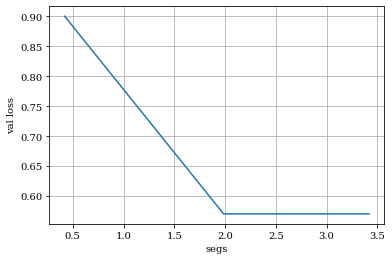

In [ ]:
time   = model.results_dict['nbeats']['optimization_times']
losses = model.results_dict['nbeats']['optimization_losses']
plt.plot(time, losses)
plt.xlabel('segs')
plt.ylabel('val loss')
plt.grid()
plt.show()

<a name="cell-5"></a>
### 5. Evaluate Results

Here we wrangle the numpy predictions to evaluate and plot the predictions.

In [ ]:
# Asserting equal outputs between nbeats and rnn
assert((model.results_dict['nbeats']['y_true'] == model.results_dict['rnn']['y_true']).mean() == 1)

In [ ]:
y_hat_nhits  = model.results_dict['nhits']['y_hat']
y_hat_nbeats = model.results_dict['nbeats']['y_hat']
y_hat_rnn    = model.results_dict['rnn']['y_hat']
y_true       = model.results_dict['nbeats']['y_true']

print('\n Shapes')
print('1. y_hat_nhits.shape (N,T,H) \t', y_hat_nhits.shape)
print('1. y_hat_nbeats.shape (N,T,H)\t', y_hat_nbeats.shape)
print('1. y_hat_rnn.shape (N,T,H)\t', y_hat_rnn.shape)
print('1. y_true.shape (N,T,H)\t\t', y_true.shape)


 Shapes
1. y_hat_nhits.shape (N,T,H) 	 (7, 170, 24)
1. y_hat_nbeats.shape (N,T,H)	 (7, 170, 24)
1. y_hat_rnn.shape (N,T,H)	 (7, 170, 24)
1. y_true.shape (N,T,H)		 (7, 170, 24)


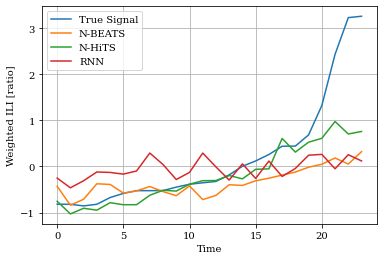

In [ ]:
w_idx = 0
u_idx = 0

plt.plot(y_true[u_idx,w_idx,:], label='True Signal')
plt.plot(y_hat_nbeats[u_idx,w_idx,:], label='N-BEATS')
plt.plot(y_hat_nhits[u_idx,w_idx,:], label='N-HiTS')
plt.plot(y_hat_rnn[u_idx,w_idx,:], label='RNN')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Weighted ILI [ratio]')
plt.grid()
plt.show()

In [ ]:
model.best_model